# DM5: Modèles de taux de décharge : réseau excitateur-inhibiteur

Dans ce devoir, nous allons poursuivre l'étude de la dynamique de réseaux de neurones où différentes *populations de neurones* sont représentés par leur taux de décharge moyen. Ces populations peuvent être couplées par des connexions synaptiques, ce qui rend la dynamique de ces modèles potentiellement très riche.

## Deux populations couplées : le réseau Excitateur-Inhibiteur (E-I)

Pour deux populations de neurones excitateurs et inhibiteurs, un modèle de taux de décharge peut prendre la forme suivante :

$$\tau \frac{d r_E(t)}{dt} =  \Phi(I_{ext,E} + w_{EE}r_E(t) + w_{EI}  r_I(t) )  -  r_E(t) $$
$$\tau \frac{d r_I(t)}{dt} =  \Phi(I_{ext,I} + w_{IE}r_E(t) + w_{II}  r_I(t) )  -  r_I(t) $$

Ici, il y a désormais quatre poids effectifs de connexions synaptiques, des excitateurs vers excitateurs et inhibiteurs, $w_{EE}, w_{IE} >0$, et des inhibiteurs vers excitateurs et inhibiteurs, $w_{EI}, w_{II} < 0$. Pour réduire la compléxité, nous considérons $w_{II}=0$ par la suite.

Comme pour un modèle avec une seule population, nous pouvons intégrer numériquement les équations dynamiques couplées pour $r_E(t), r_I(t)$. 

**Astuce :** Nous pouvons écrire la dynamique (comme pour le modèle FitzHugh-Nagumo) pour un système "vectoriel" à deux dimensions, $\vec{r}(t) = (r_E(t), r_I(t))$.

**Remarque :** Au lieu de chercher le ou les point(s) fixe(s) pour des paramètres donnés, il est beaucoup plus simple d'imposer un point fixe $\vec{r}^* = (r_E^*, r_I^*)$ et de déterminer le courant externe nécessaire qu'il faut pour obtenir ce point fixe, quand la matrice des connexions est donnée. (Pour le réseau E-I, ici la dynamique nous intéresse d'avantage que la détermination du point fixe pour des paramètres donnés.) Pour $\vec{r}^*$ donné, nous avons donc

$$
\begin{aligned}
\Phi(\vec{I}_{ext}+W\vec{r}^*) - \vec{r}^* &= 0 \\
\Leftrightarrow \quad \Phi(\vec{I}_{ext}+W\vec{r}^*) &= \vec{r}^* \\
\Leftrightarrow\quad  \vec{I}_{ext} + W\vec{r}^* &= \Phi^{-1}(\vec{r})^* \\
\Leftrightarrow \quad \vec{I}_{ext} &= \Phi^{-1}(\vec{r})^* - W\vec{r}^*,
\end{aligned}
$$

où $\Phi^{-1}(r)$ est la fonction inverse de $\Phi(I)$, que nous connaissons pour $\Phi(I)$ définie telle que dans le TD et DM sur les modèles de taux précédent. 

*Attention* : Si on a ainsi fait en sorte de connaître très précisement le point fixe, il faut surtout éviter de choisir le point fixe comme valeur(s) intiale(s) pour la dynamique, car au point fixe rien ne se passe par définition - il faut choisir un point de départ légèrement décalé. (C'était cela que j'avais oublié lorsque j'ai essayé de montrer l'activité du réseau à deux populations en *live*.)


In [1]:
# import necessary modules for numerics and plotting
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Definition of the f-I curve 

# set standard parameters 
# --> these will be used as default parameters
# in the function definitions
rmax = 500.0     # (could be Hz)
Ihalf = 10.0   # (could be pA)
kappa = 0.2  # (1/unit of current)

# f-I curve
def fI(I):
    """fI(I, kwargs**) returns the population firing rate (in Hz) 
    for a given input current I (in mV)."""
    return rmax*0.5*(1.0+np.tanh((I-Ihalf)*kappa))

# we need the inverse function as well:
def fI_inv(r):
    y = 2.0*r/rmax - 1.0
    return np.arctanh(y)/kappa + Ihalf

# and also its derivative with respect to current
def fI_deriv(I):
    y = (I-Ihalf)*kappa
    return rmax*0.5*(1.0-np.tanh(y)**2)*kappa

In [47]:
# définir la dynamique pour le vecteur
# r = (r_E, r_I)

tau = 1

def drdt_explicit(r, t, Iext, W):
    rE, rI = r
    wEE, WEI, wIE, wII = W.flatten()
    IEtotal = Iext[0] + wEE*rE + wEI*rI
    IItotal = Iext[1] + wIE*rE + wII*rI
    drEdt = (fI(IEtotal) - rE)/tau
    drIdt = (fI(IItotal) - rI)/tau
    return np.array([drEdt, drIdt])

# --> beaucoup plus élégant : la
# fonctionnalité du calcul vectoriel 
# avec les arrays de numpy

def drdt_matrix(r, t, Iext, W):
    Itotal = Iext + W.dot(r)
    return (fI(Itotal) - r)/tau

# la matrice des poids de connexions
# récurrentes et entre populations

W = np.array([[1.1, -2 ],
              [1, 0.]])

# au lieu

rstar = np.array([5., 10.])
Iext = fI_inv(rstar) - W.dot(rstar)

r0a = 1.1 * rstar
r0b = np.array([10,100])

dt = 0.01
t = np.arange(0,100,dt)

# We can use odeint from scipy.integrate to solve the 
# equations
from scipy.integrate import odeint

rta = odeint(drdt_matrix, r0a, t, args=(Iext, W))
rtb = odeint(drdt_matrix, r0b, t, args=(Iext, W))

<IPython.core.display.Javascript object>


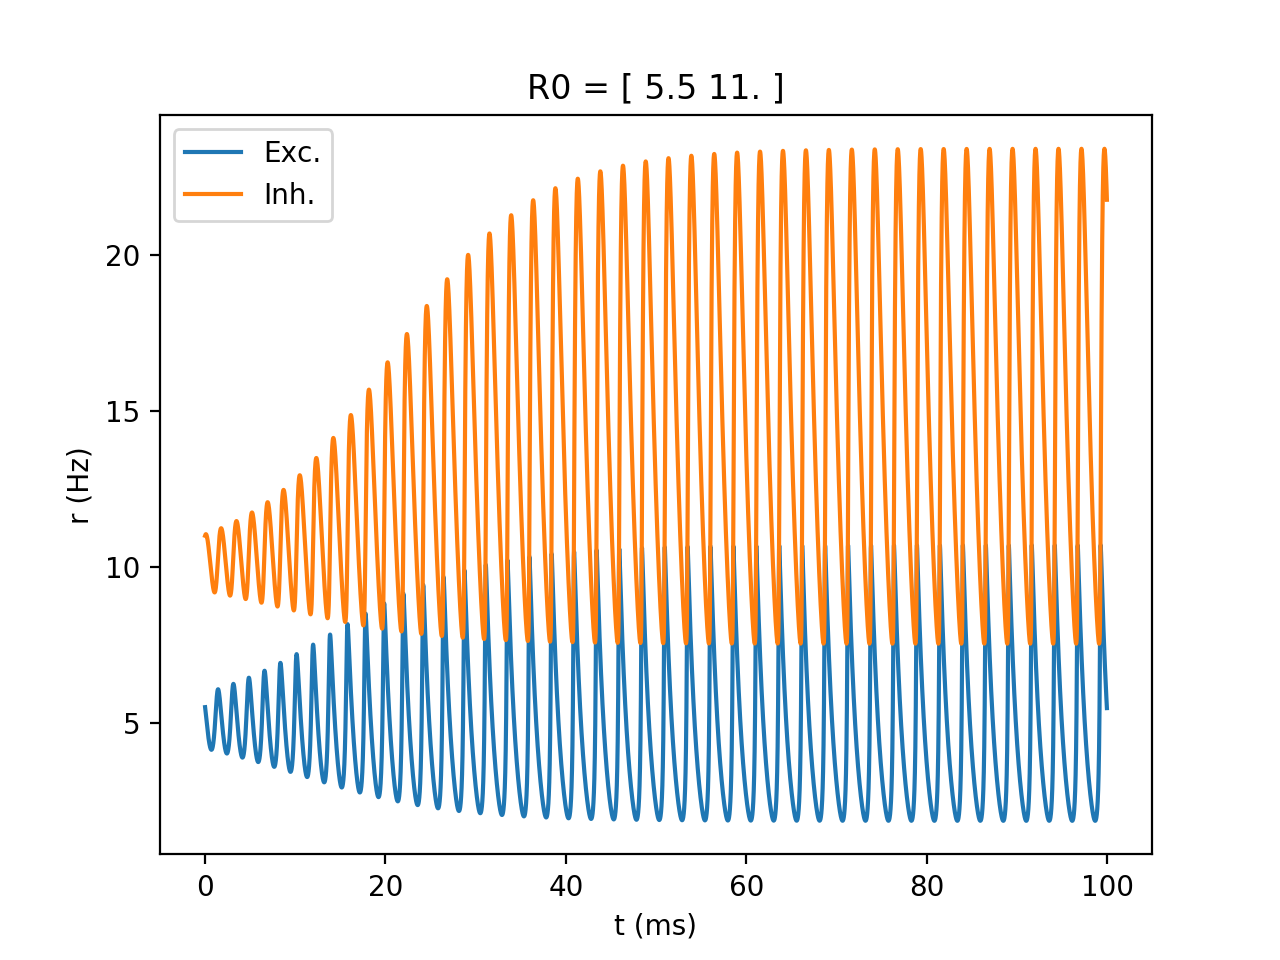

<IPython.core.display.Javascript object>


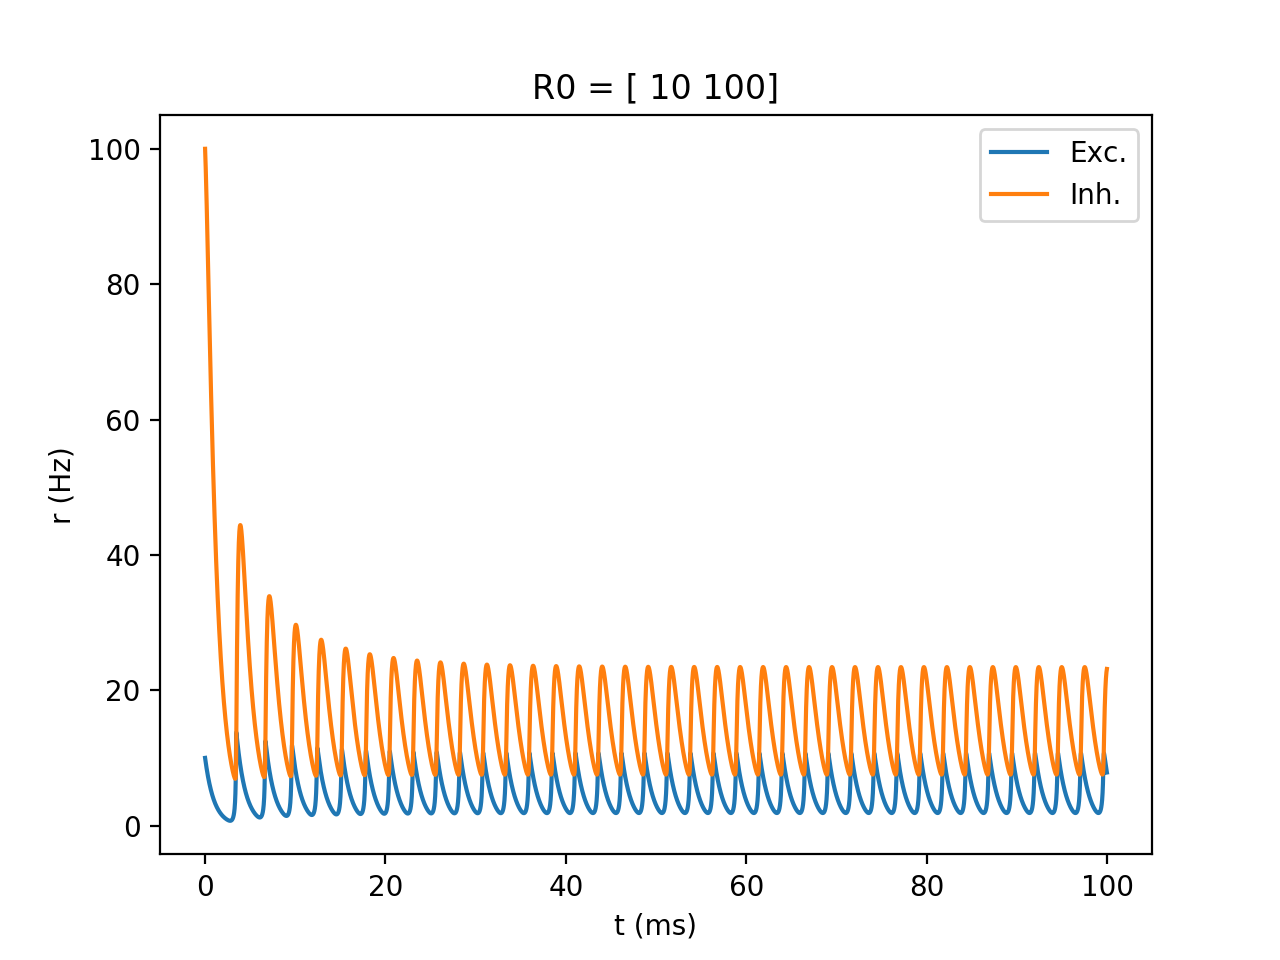

Text(0, 0.5, 'r (Hz)')

In [48]:
# Plot the dynamics for the two coupled populations,
# for both initial conditions

fig, ax = plt.subplots()
ax.set_title('R0 = '+str(r0a))
ax.plot(t, rta)
ax.legend(labels=['Exc.', 'Inh.'])
ax.set_xlabel('t (ms)')
ax.set_ylabel('r (Hz)')

fig, ax = plt.subplots()
ax.set_title('R0 = '+str(r0b))
ax.plot(t, rtb)
ax.legend(labels=['Exc.', 'Inh.'])
ax.set_xlabel('t (ms)')
ax.set_ylabel('r (Hz)')

On voit bien l'émergence d'une oscillation d'activité des deux populations ! Cela s'appele un *cycle limite*, qui apparaît très clairement si on plotte $r_I$ vs. $r_I$ (dans un tel plot, on perd la notion temporelle par contre) :


<IPython.core.display.Javascript object>


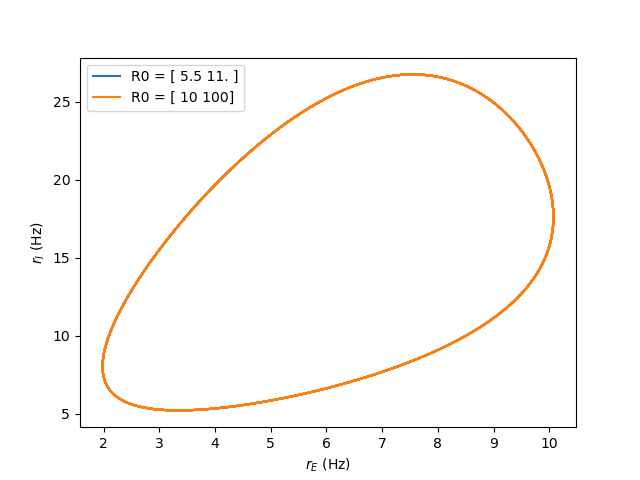

Text(0, 0.5, '$r_I$ (Hz)')

In [16]:

# Plot only last 2000 time points
# (discard initial transient towards stable limit cycle)
i0 = 8000

fig, ax = plt.subplots()
ax.plot(rta[i0:,0], rta[i0:,1], label='R0 = '+str(r0a))
ax.plot(rtb[i0:,0], rtb[i0:,1], label='R0 = '+str(r0b))
ax.legend()
ax.set_xlabel('$r_E$ (Hz)')
ax.set_ylabel('$r_I$ (Hz)')

**Observation :** Le cycle limite est parfaitement identique pour les deux conditions stable !

### Exercice 

Déterminez la *période d'oscillation* (l'interval entre deux répétitions de l'activité, par ex. d'un pic du réseau excitateur au prochain) en fonction de l'inhibition $w_{EI}\in (-2,-0.5)$, `wEI = np.arange(-2,-0.51,0.1)`. Dans l'exemple ci-dessus, $w_{EI}=-1$ (c'est l'élément `W[0,1]` de la matrice de connexion `W`). Variez uniquement le poids de cette connexion sans modifier les autres paramètres. 

**Astuce :** Pour mesurer la période d'oscillation sur le cycle limite, utilisez la distance entre les deux derniers pics d'activité d'une des deux populations. Pour cela, vous devez déterminez les indices des minima locaux dans les arrays d'activité (`rta` ou `rtb` dans l'exemple ci-dessus, avec `rta[:,0]`/`rtb[:,0]` étant le taux de décharge de la population excitatrice et `rta[:,1]`/`rtb[:,1]` le taux de décharge de la population inhibitrice). 

N'oubliez pas que la durée d'un pas de temps est donnée par `dt`.

Plottez la période $T$ d'oscillation en fonction de $w_{EI}$. Est-ce que davantage d'inhibition accélère ou décelère l'oscillation ? 

In [66]:

# poids de connexion I->E à explorer
wEI = np.arange(-2,-0.49,0.1)
nw = len(wEI)

# array pour les valeurs de période d'oscillation
T = np.zeros(nw)

rts = []

# Itération sur les différentes valeurs du poid w_EI
for i in range(nw):
    # modification de la matrice de connectivité
    W = np.array([[1.1, wEI[i] ],
                  [1, 0.]])
    
    # calculer la nouvelle valeur pour le courant 
    # externe pour rester au même point fixe 
    Iext = fI_inv(rstar) - W.dot(rstar)
    
    # solution de la dynamique de réseau
    # (partir d'un seul état initial suffit)
    rt = odeint(drdt_matrix, r0a, t, args=(Iext, W))
    rts.append(rt)
    
    # extraction des minima locaux:
    # -> comparaison avec l'élément antérieur 
    #    et comparaison avec l'élément suivant
    # ici: array boolean avec 'vrai' et 'faux' 
    # qui permet une opération sur l'array des valeurs,
    # mais utiliser une boucle est également possible
    is_minimal = (rt[:-2,0]>=rt[1:-1,0]) * (rt[2:,0]>rt[1:-1,0])
    inds = np.where(is_minimal)[0]
    
    # utiliser la distance entre les deux derniers pour estimer
    # la période d'oscillation
    T[i] = dt*np.diff(inds)[-1]
    


<IPython.core.display.Javascript object>


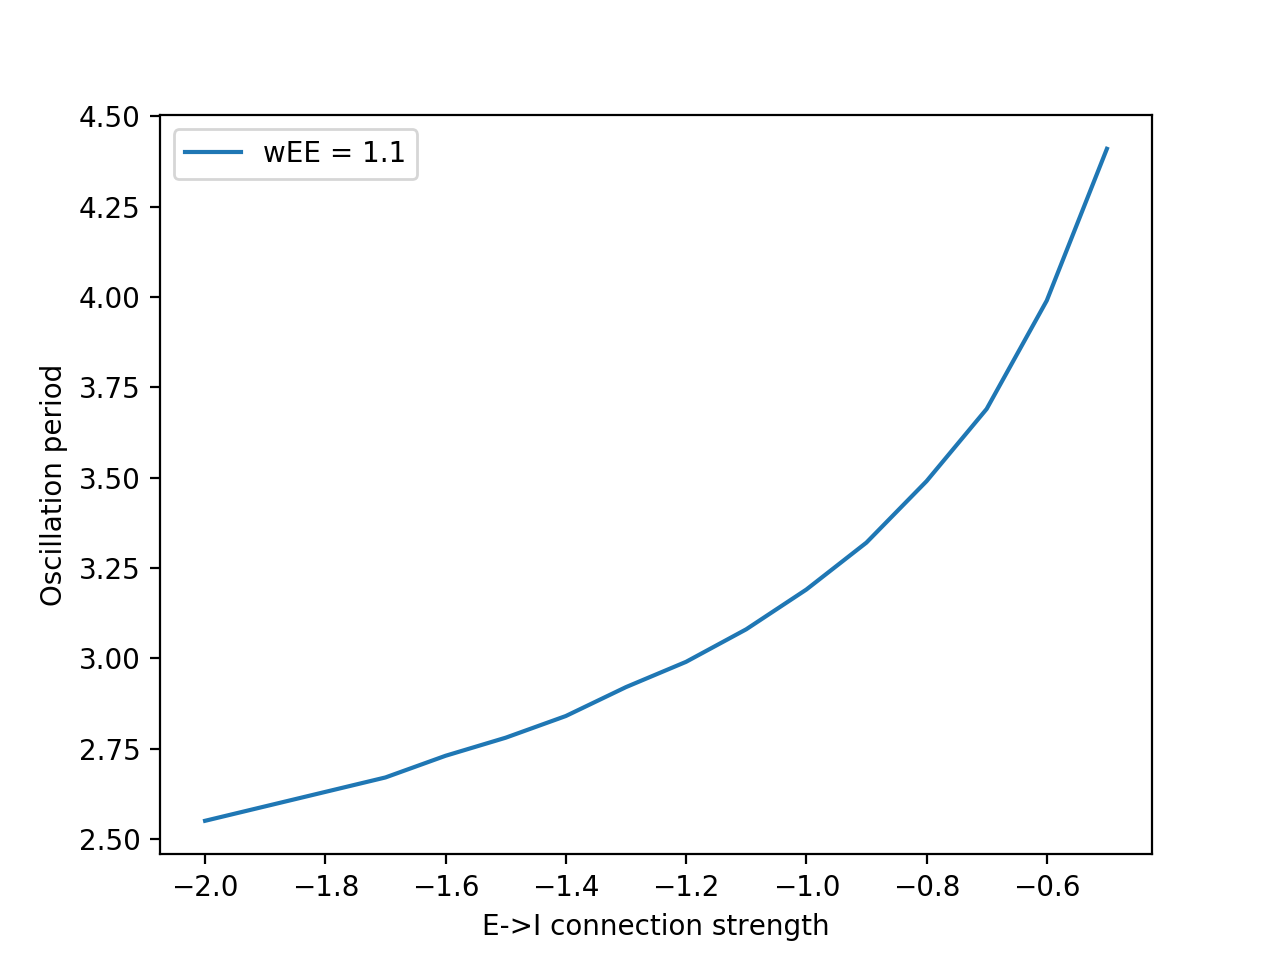

Text(0, 0.5, 'Oscillation period')

In [67]:
# Plotter le résultat

fig, ax = plt.subplots()
ax.plot(wEI, T, label='wEE = %g'%W[0,0])
ax.legend()
ax.set_xlabel('E->I connection strength')
ax.set_ylabel('Oscillation period')

**Observation :** Avec plus d'inhibition ($w_{EI}$ plus négatif) la période est plus courte, l'explication étant que l'inhibition arrive plus rapidement à couper l'excitation dans le réseau.  

### (Petit) BONUS

On peut également se demander comment le cycle limite (sa forme) varie en fonction des paramètres. Superposez les cycles limites pour les valeurs `wEI = np.arange(-2,-0.51,0.5)`. Comment est-ce que le cycle limite est déformé avec davantage d'inhibition ? Si vous augmentez un petit peu l'excitation récurrente (à $w_{EE}= 1.2$), est-ce que le changement du cycle limite est plus ou moins important ?

<IPython.core.display.Javascript object>


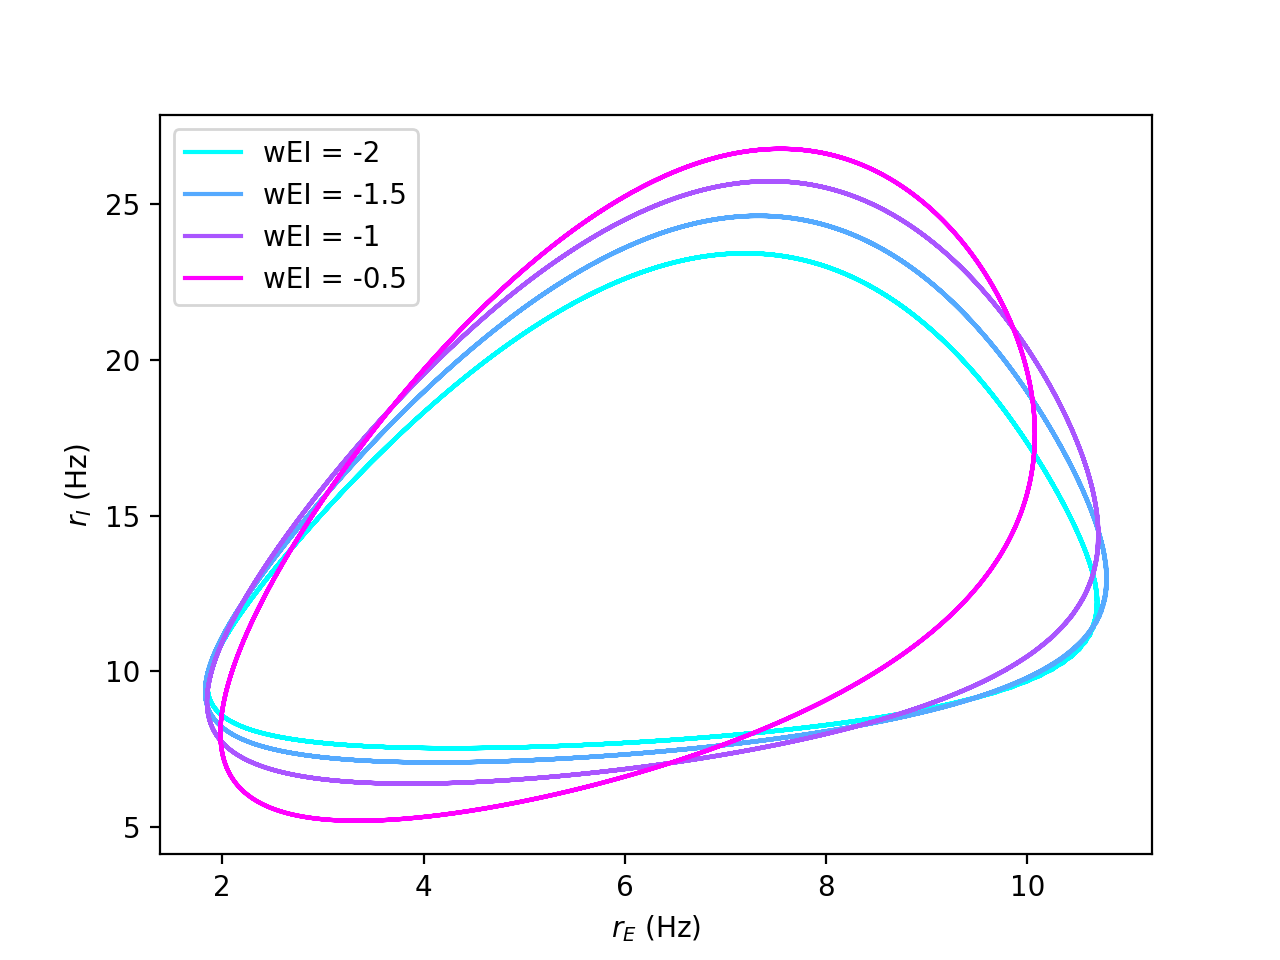

Text(0, 0.5, '$r_I$ (Hz)')

In [68]:
# Affichons d'abord le changement du cycle limite pour wEI uniquement

# définir un 'colormap' pour avoir un dégradé de couleurs
cols = plt.get_cmap('cool',nw)

fig, ax = plt.subplots()
for i in [0,5,10,15]:
    ax.plot(rts[i][i0:,0], rts[i][i0:,1], c=cols(i), label='wEI = %g'%wEI[i])
ax.legend()
ax.set_xlabel('$r_E$ (Hz)')
ax.set_ylabel('$r_I$ (Hz)')


In [63]:

# array pour les valeurs de période d'oscillation
T2 = np.zeros(nw)

rts2 = []

# Itération sur les différentes valeurs du poid w_EI
for i in range(nw):
    # modification de la matrice de connectivité
    W = np.array([[1.2, wEI[i] ],
                  [1, 0.]])
    
    # calculer la nouvelle valeur pour le courant 
    # externe pour rester au même point fixe 
    Iext = fI_inv(rstar) - W.dot(rstar)
    
    # solution de la dynamique de réseau
    # (partir d'un seul état initial suffit)
    rt = odeint(drdt_matrix, r0a, t, args=(Iext, W))
    rts2.append(rt)
    
    # extraction des minima locaux:
    # -> comparaison avec l'élément antérieur 
    #    et comparaison avec l'élément suivant
    # ici: array boolean avec 'vrai' et 'faux' 
    # qui permet une opération sur l'array des valeurs,
    # mais utiliser une boucle est également possible
    is_minimal = (rt[:-2,0]>=rt[1:-1,0]) * (rt[2:,0]>rt[1:-1,0])
    inds = np.where(is_minimal)[0]
    
    # utiliser la distance entre les deux derniers pour estimer
    # la période d'oscillation
    T2[i] = dt*np.diff(inds)[-1]


<IPython.core.display.Javascript object>


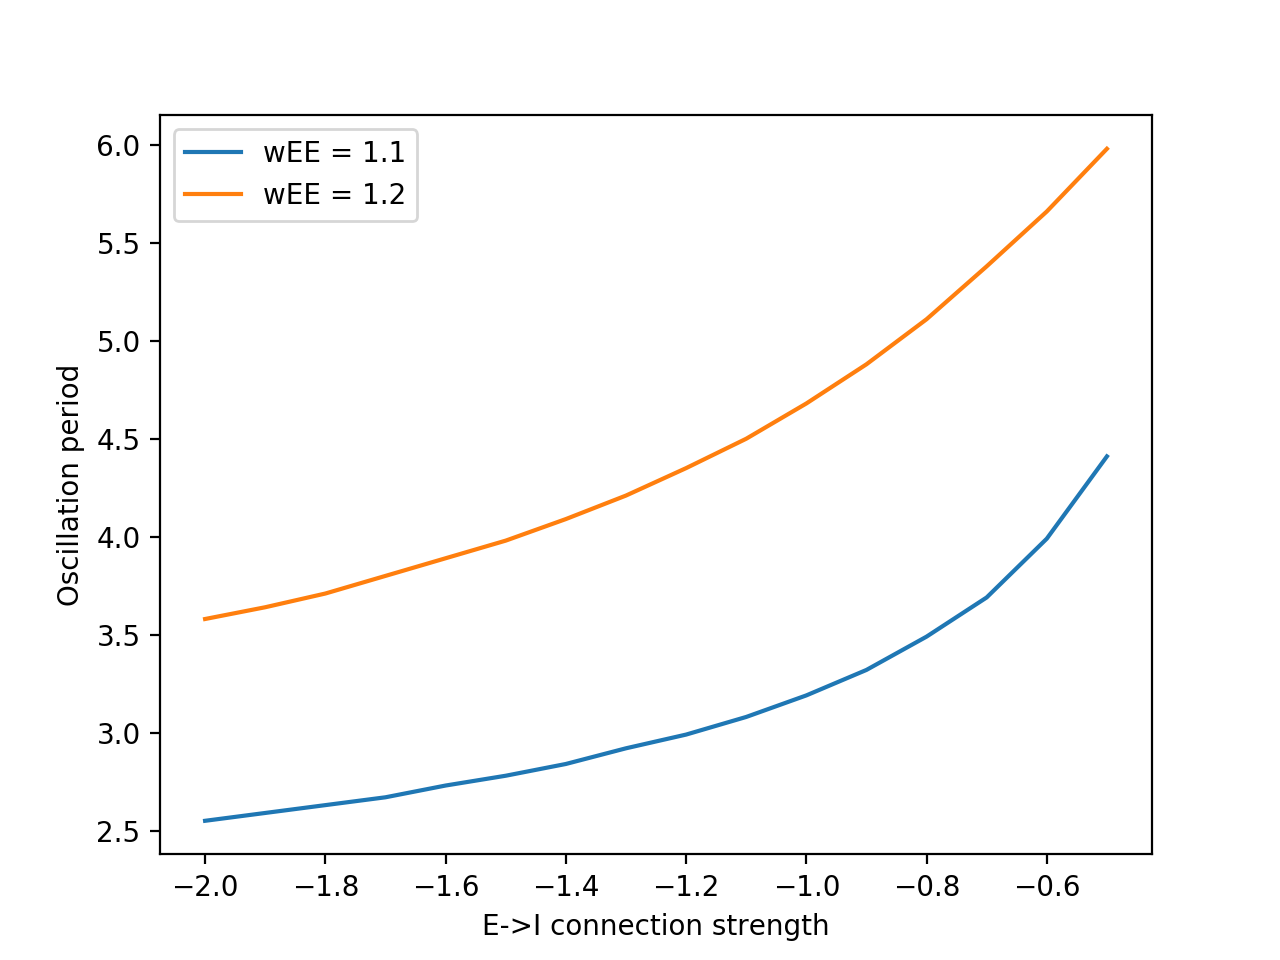

Text(0, 0.5, 'Oscillation period')

In [69]:
# Plotter le résultat

fig, ax = plt.subplots()
ax.plot(wEI, T, label='wEE = 1.1')
ax.plot(wEI, T2, label='wEE = 1.2')
ax.legend()
ax.set_xlabel('E->I connection strength')
ax.set_ylabel('Oscillation period')

<IPython.core.display.Javascript object>


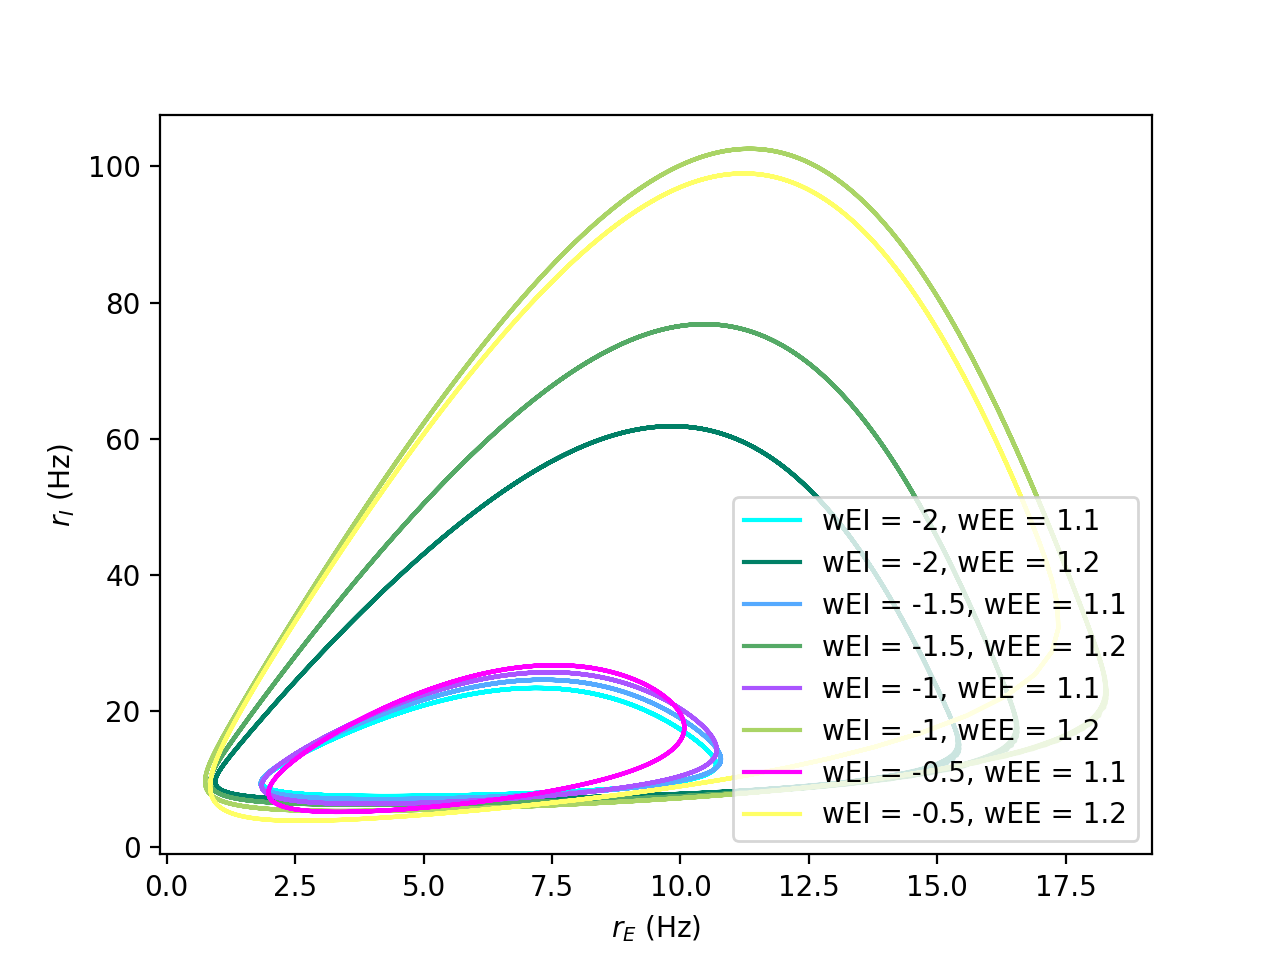

Text(0, 0.5, '$r_I$ (Hz)')

In [74]:
# définir un 'colormap' pour avoir un dégradé de couleurs
cols = plt.get_cmap('cool',nw)
cols2 = plt.get_cmap('summer',nw)

fig, ax = plt.subplots()
for i in [0,5,10,15]:
    ax.plot(rts[i][i0:,0], rts[i][i0:,1], c=cols(i), label='wEI = %g, wEE = 1.1'%wEI[i])
    ax.plot(rts2[i][i0:,0], rts2[i][i0:,1], c=cols2(i), label='wEI = %g, wEE = 1.2'%wEI[i])
ax.legend()
ax.set_xlabel('$r_E$ (Hz)')
ax.set_ylabel('$r_I$ (Hz)')

**Observation :** On va très clairement que le changement en $w_{EE}$ change la forme du cycle limite beaucoup plus qu'un changement de $w_{EI}$. Par contre la durée ne change pas si drastiquement, quoiqu'elle change aussi.